# IML NET

In [2]:
from model import IMLE_net
from model.IMLE_net.inference import build_scores, transform_ecg_for_inference
import os
import numpy as np
from data import ptbxl
from utils import setCWDToProjectDir

In [3]:
setCWDToProjectDir()
print(f"Our current working directory is {os.getcwd()}")

Our current working directory is D:\cardiovascular-ai


## Author's model and weight

Model configuration:
	 signal_len: 1000
	 input_channels: 12
	 beat_len: 50
	 kernel_size: 8
	 num_blocks_list: [2, 2, 2]
	 lstm_units: 32
	 start_filters: 16
	 classes: 5
	 attention_dim: 32

Model: "IMLE-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 1000, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 50, 1)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 50, 16)       144         ['tf.reshape[0][0]']           

d:\cardiovascular-ai\.venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


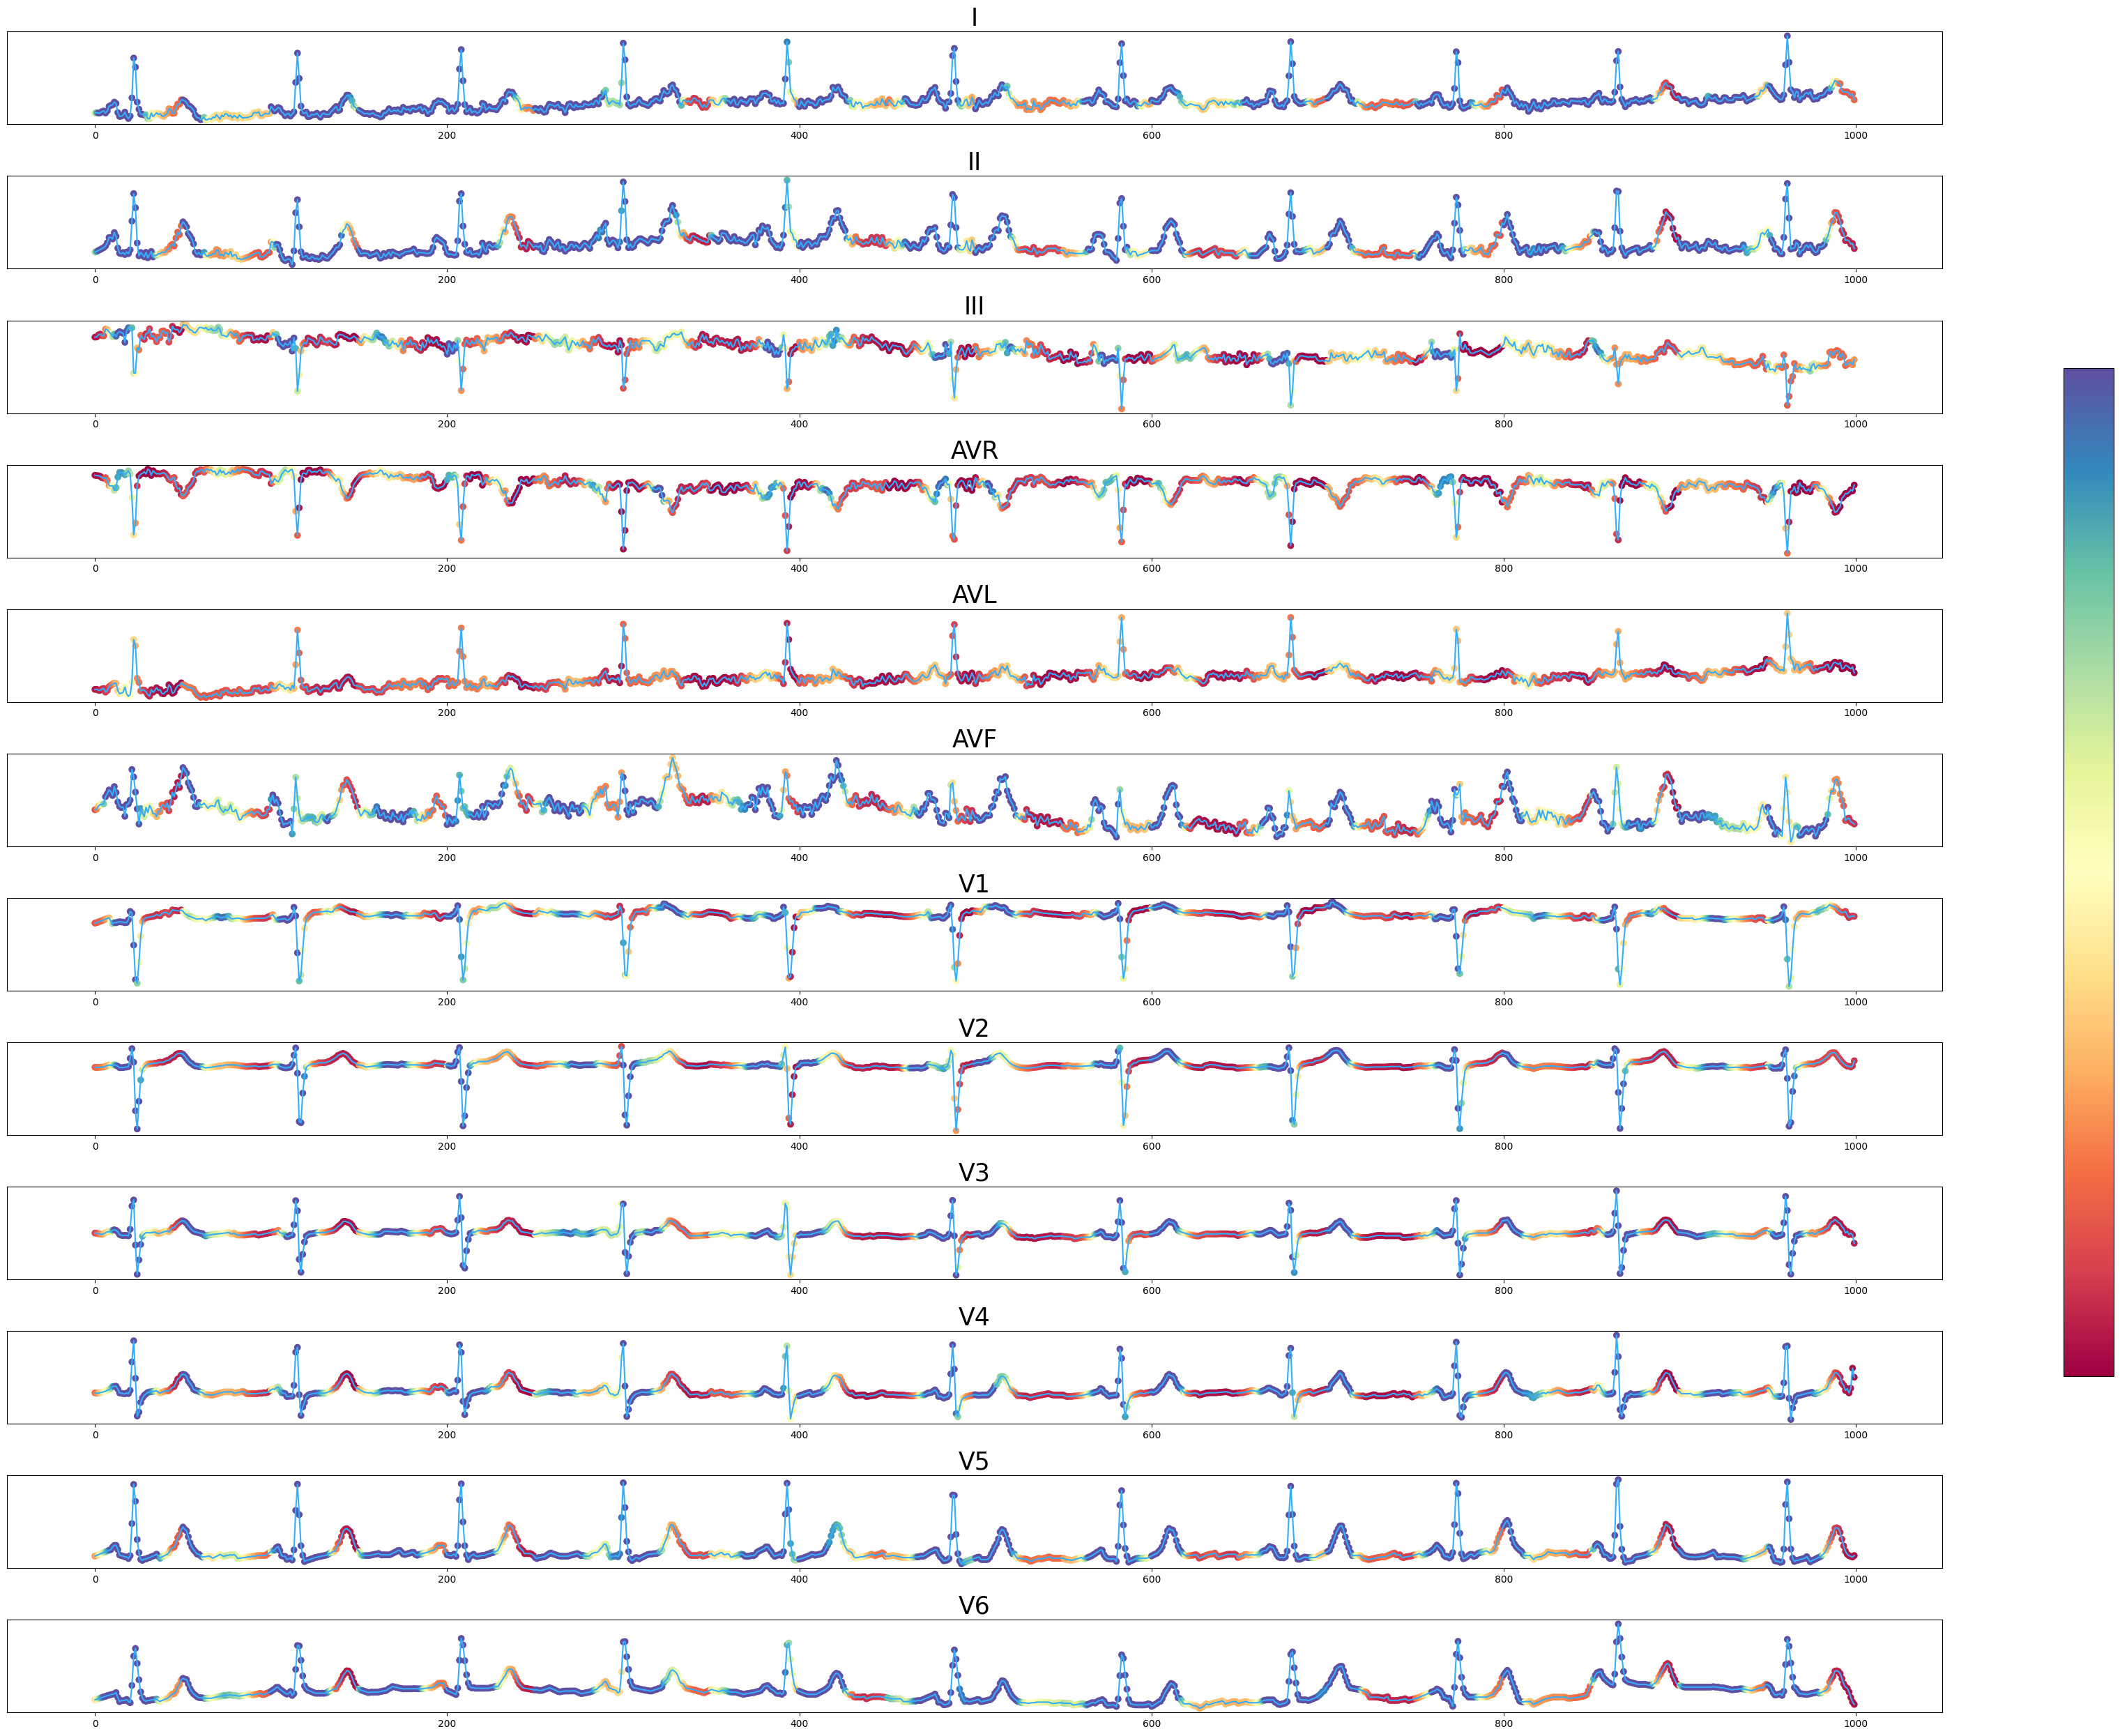

In [4]:


dataset = ptbxl.PTBXL(sampling_rate=ptbxl.SamplingRate.HZ_100)
record = dataset.load_record(1)
weight_path = os.path.join(os.getcwd(), 'ckpts', 'imle_net_weights.h5')

config = IMLE_net.Config()

# Set the configuration parameters for the Author's model (imle_net_weights)
config.attention_dim = 32
config.lstm_units = 32
config.start_filters = 16

#Print all config values
print("Model configuration:")
for key, value in config.__dict__.items():
    print(f"\t {key}: {value}")
print("")
model = IMLE_net.build_imle_net(config)
model.load_weights(weight_path)

data = record.data
data = np.expand_dims(data, axis=0)
data = transform_ecg_for_inference(data)
print("Data shape after transformation:", data.shape)
build_scores(model, data, config)





## Community model and weight

Model configuration:
	 signal_len: 1000
	 input_channels: 12
	 beat_len: 50
	 kernel_size: 8
	 num_blocks_list: [2, 2, 2]
	 lstm_units: 64
	 start_filters: 32
	 classes: 5
	 attention_dim: 64

Model: "IMLE-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 12, 1000, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.reshape_3 (TFOpLambda)      (None, 50, 1)        0           ['input_2[0][0]']                
                                                                                                  
 conv1d_15 (Conv1D)             (None, 50, 32)       288         ['tf.reshape_3[0][0]']         

d:\cardiovascular-ai\.venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



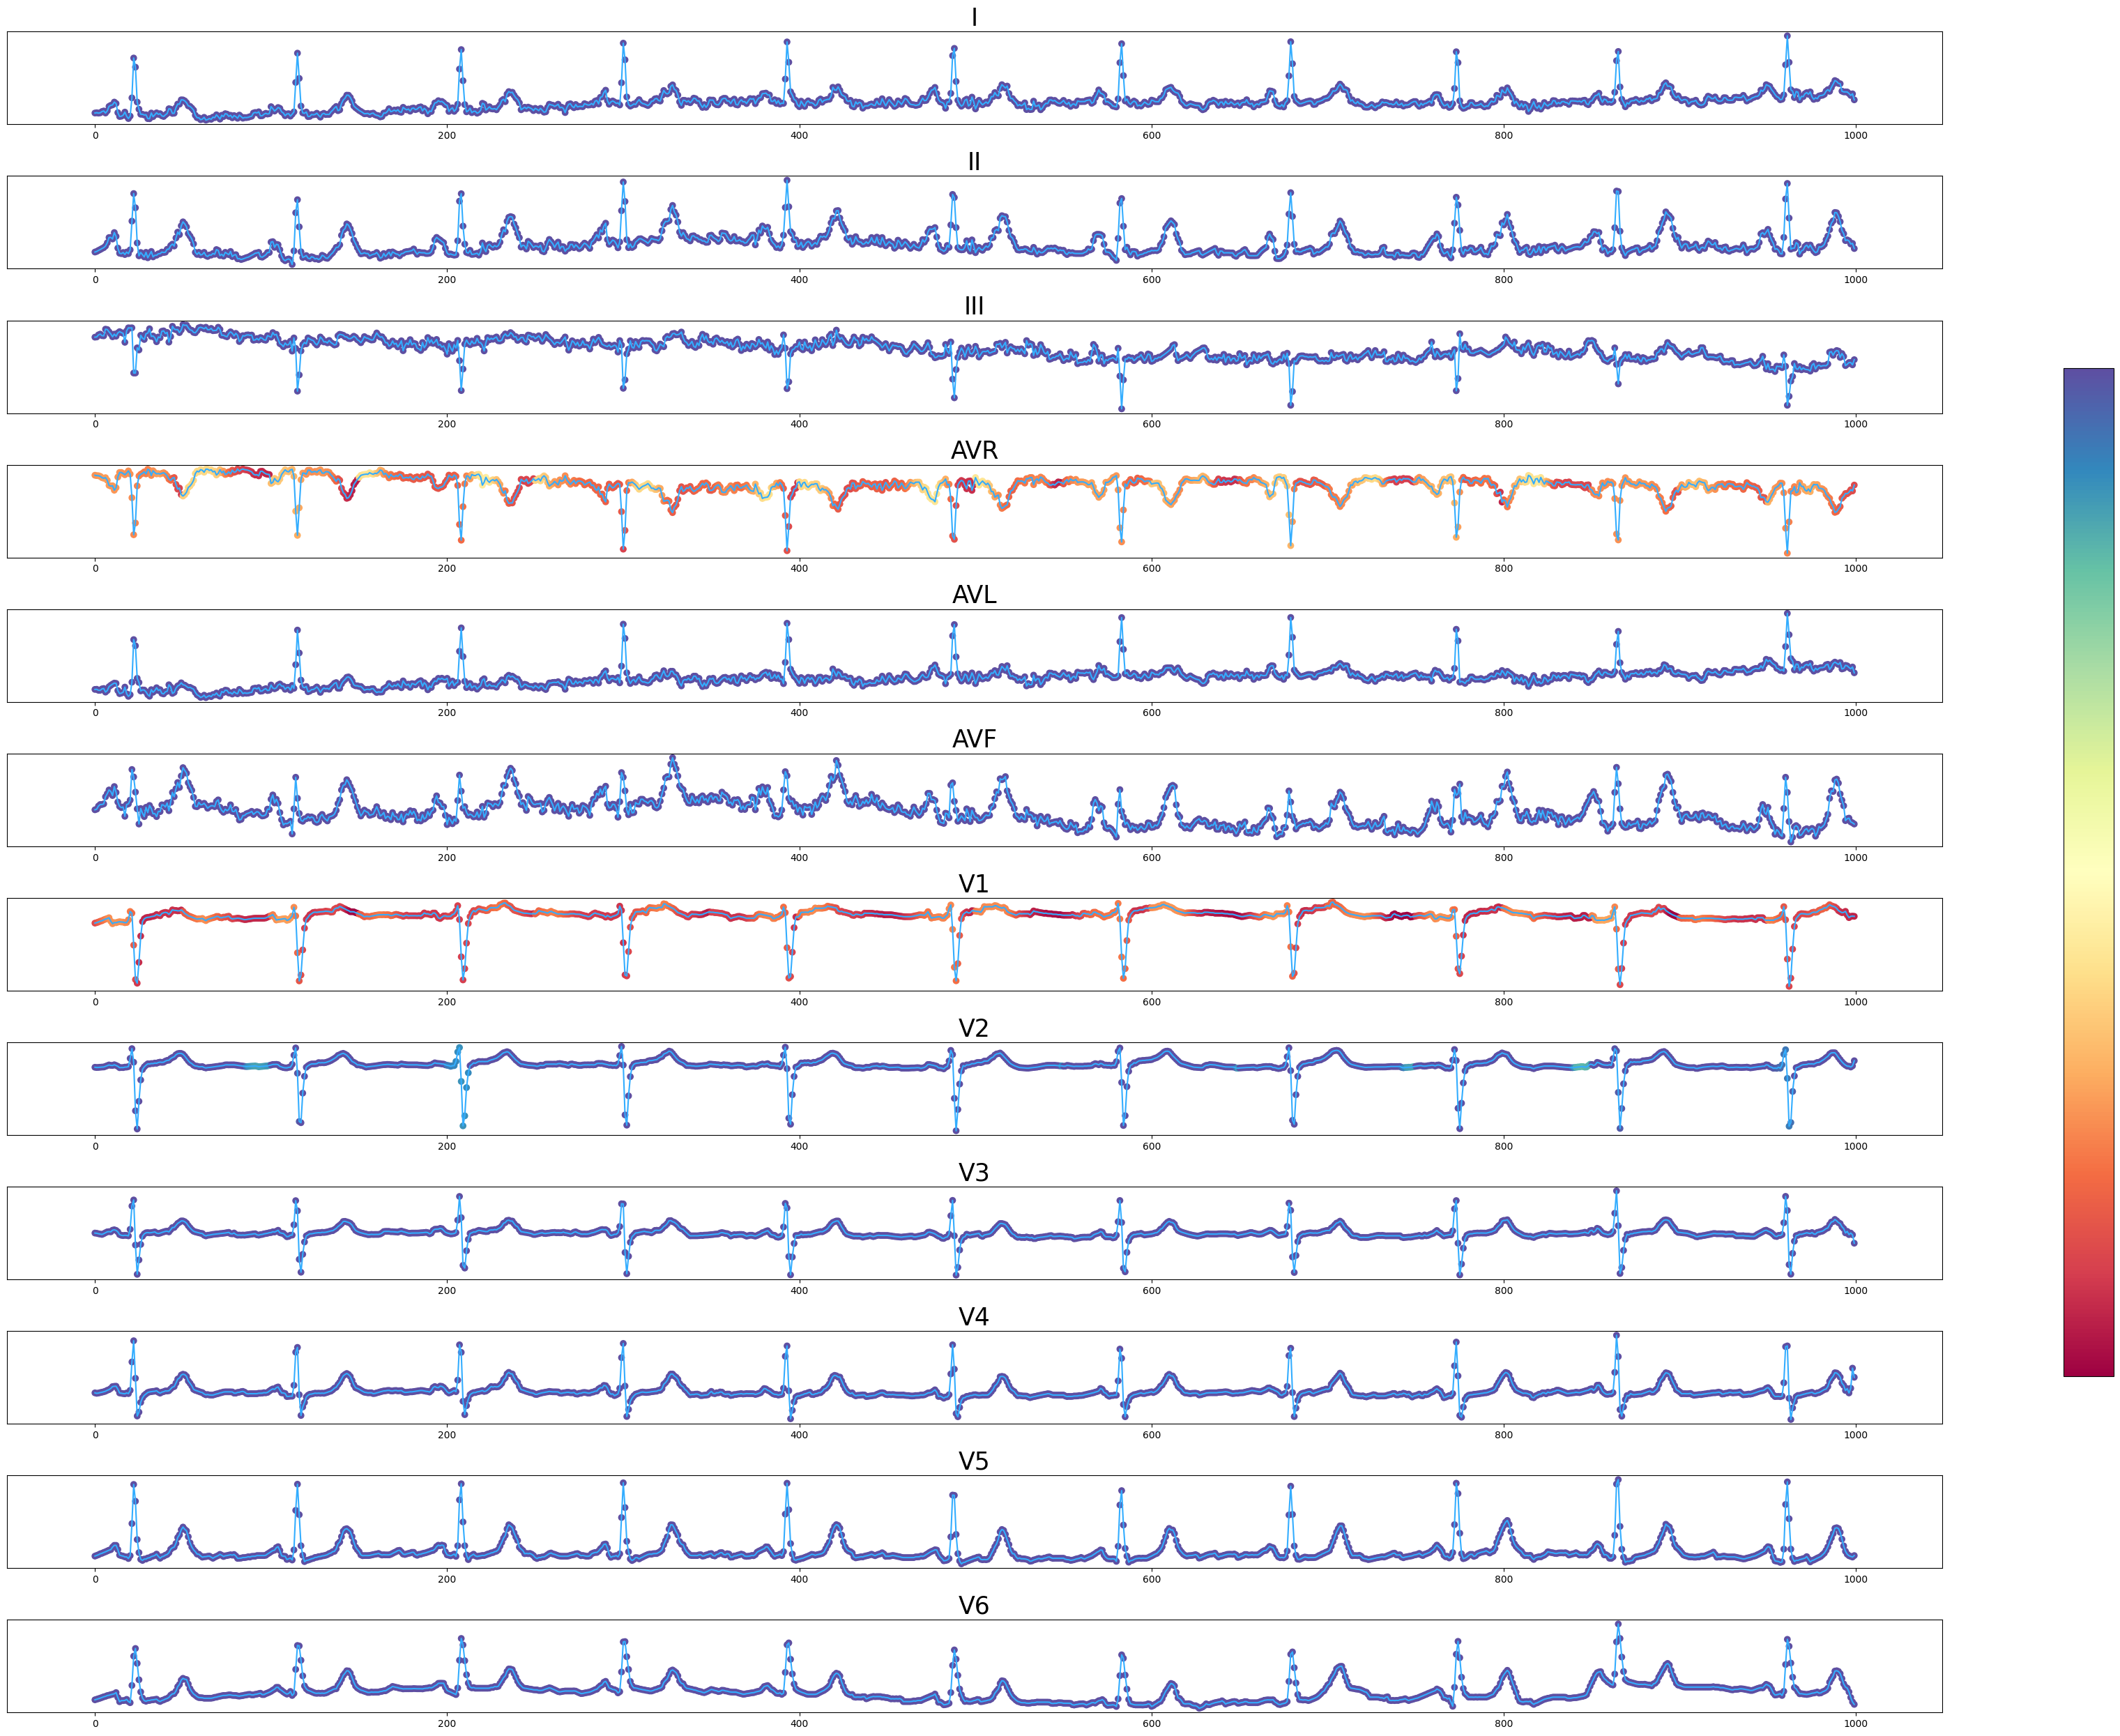

In [5]:


dataset = ptbxl.PTBXL(sampling_rate=ptbxl.SamplingRate.HZ_100)
record = dataset.load_record(1)
weight_path = os.path.join(os.getcwd(), 'ckpts', 'imle_net_community_weights.h5')

config = IMLE_net.Config()

#Print all config values
print("Model configuration:")
for key, value in config.__dict__.items():
    print(f"\t {key}: {value}")
print("")
model = IMLE_net.build_imle_net(config)
model.load_weights(weight_path)

data = record.data
data = np.expand_dims(data, axis=0)
data = transform_ecg_for_inference(data)
print("Data shape after transformation:", data.shape)
build_scores(model, data, config)



